In [52]:
%matplotlib inline
import pandas as pd
from SALib.sample import latin, saltelli, fast_sampler
from SALib.sample.morris import sample
from SALib.analyze import sobol, fast, morris
from functions.stylizedfacts import *
from functions.evolutionaryalgo import *
from functions.sensitivity_analysis import *
from functions.helpers import *
from init_objects import *
from simfinmodel import *
import matplotlib.pyplot as plt
from matplotlib import style
from pandas_datareader import data
#import quandl
from hurst import compute_Hc#, random_walk
import json
import scipy
import math
import ast
import scipy.stats as st

In [2]:
style.use('seaborn-ticks')

In [3]:
def confidence_interval(data):
    return st.t.interval(0.95, len(data)-1, loc=np.mean(data), scale=st.sem(data))

# Data

In [55]:
start_date = '2008-01-01'
end_date = '2018-08-16'

spy_nom_price = data.DataReader("SP500", 
                       start=start_date, 
                       end=end_date, 
                       data_source='fred')["SP500"].dropna()
spy_nom_returns = spy_nom_price.pct_change()[1:]

shiller_data = pd.read_excel('http://www.econ.yale.edu/~shiller/data/ie_data.xls', header=7)[:-3]
schul_data = pd.read_excel('http://www.macrohistory.net/JST/JSTmoneyR3.xlsx', sheet_name='Data')[['year', 'country', 'stir']]
schul_data = schul_data.loc[(schul_data.country == 'USA')]
schul_data = schul_data.iloc[1:]
schul_data = schul_data.set_index('year')

In [56]:
table1_descriptives = pd.DataFrame()
table1_descriptives['returns'] = spy_nom_returns.describe()
table1_descriptives['spy_real'] = shiller_data['Price'].describe()
table1_descriptives['Dividend'] = shiller_data['Dividend'].describe()
table1_descriptives['T-bill'] = schul_data['stir'].describe()
table1_descriptives = table1_descriptives.round(decimals=2)
table1_descriptives.to_csv('table1.csv', sep='&')
table1_descriptives

,returns,spy_real,Dividend,T-bill
count,2293.00,1781.00,1781.00,146.00
mean,0.00,538.62,15.86,4.09
std,0.01,589.94,9.30,2.93
min,-0.07,69.43,5.12,0.09
25%,-0.00,174.70,8.80,1.89
50%,0.00,262.44,13.20,3.51
75%,0.01,644.66,20.17,5.42
max,0.05,2948.18,55.79,16.39


## Calculating the fundamental value


To be able to calculate the fundamental value, I extend the annual historical interest data to monthly data. 

In [57]:
schul_data['stir']

short_term_int = []
counter = -1
for idx in range(len(shiller_data)):
    if idx % 12 == 0:
        counter += 1
    try:
        short_term_int.append(schul_data['stir'].iloc[counter])
    except:
        pass

So that, I can calculate the discount rate $i_t + r$ for the NPV model. Where $i_t$ is the short-term interest rate time $t$ while $r$ represents the equity price premium which is assumed to be constant at 5.2 which is the level of the equity risk premium estimated by [Avdis & Wachter (2017)](https://doi.org/10.1016/j.jfineco.2017.06.003).

In [58]:
discount_rates = np.array(short_term_int) + 5.2
discount_rates = pd.Series(discount_rates).apply(div_by_hundred)

This allows me to calculate the fundamental value. I combine the Shiller and macro history datasets to calculate the fundamental value using the fixed equity premium net present value model. It states that the fundamental value is the sum of discounted future dividend rates

\begin{equation}
F_{t} = \sum_{t=1}^{\kappa} \frac{D_t}{(1 + i_t + r)^{t+1}},
\end{equation}

where $D_t$ is the dividend. I set the horizon over which to discount future dividends $\kappa$ to the point at which $\frac{D_t}{(1 + i_t + e)^t} < 0.01$. Using this equation, I calculate the ex-post fundamental value of the S\&P 500 in which I assume the annual interest rate holds for all months in that particular year.

In [60]:
fundamental_values = []
for idx, cf in enumerate(shiller_data['Dividend'][:-18]):
    next_period_divs = shiller_data['Dividend'][idx+1:]
    next_period_ints = discount_rates[idx+1]
    npv = calculate_npv(next_period_divs, next_period_ints)
    if not np.isnan(npv):
        fundamental_values.append(npv)
    else:
        break

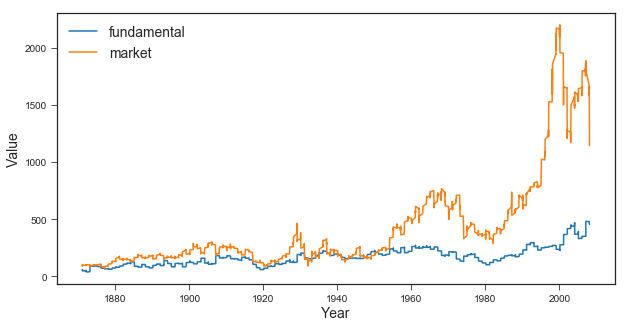

In [61]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

time=0

ax1.plot(shiller_data['Date'][time:len(fundamental_values)], fundamental_values[time:], label='fundamental')
ax1.plot(shiller_data['Date'][time:len(fundamental_values)], shiller_data['Price'][time:len(fundamental_values)], label='market')

ax1.set_ylabel('Value', fontsize='14')
ax1.set_xlabel('Year', fontsize='14')

ax1.legend(fontsize='14', loc='best')

### Bootstrapped data 
To calculate the confidence intervals for the moments later, I perform a block bootstrap on the data. To do so reliably, I make a distinction between moments which are recorded over different time lengths and perform three separate bootstrap procedures. For this procedure, I follow the approach set out by [Franke and Westerhoff (2012)](https://doi.org/10.1016/j.jedc.2011.10.004). That means that I first divide the original data into blocks of size $b$:

In [62]:
small_block_size = 250
large_block_size = 625
shiller_block_size = 205

In [63]:
small_data_blocks = []
for x in range(0, len(spy_nom_returns), small_block_size):
    small_data_blocks.append(list(spy_nom_returns[x:x+small_block_size]))
    
bootstrapped_small_series = []
for i in range(5000):
    sim_data = [random.choice(small_data_blocks) for _ in small_data_blocks]
    sim_data2 = [j for i in sim_data for j in i]
    bootstrapped_small_series.append(sim_data2)
    
large_data_blocks = []
for x in range(0, len(spy_nom_returns), large_block_size): # used to be len(spy_nom_returns[:-250])
    large_data_blocks.append(list(spy_nom_returns[x:x+large_block_size]))
    
bootstrapped_long_series = []
for i in range(5000):
    sim_data = [random.choice(large_data_blocks) for _ in large_data_blocks]
    sim_data2 = [j for i in sim_data for j in i]
    bootstrapped_long_series.append(sim_data2)

For the deviation from fundamentals, I first bootstrap the returns of both the fundamental value and the associated returns for market prices. I divided these into blocks. Then, I bootstrap these blocks of returns into new time series and apply them to the starting values of the fundamental value and real prices. This results in 5000 hypothetical time series of fundamentals and real prices.

In [64]:
fundamental_returns = pd.Series(fundamental_values).pct_change()[1:]
real_prices = shiller_data['Price'][:len(fundamental_values)]
real_prices_returns = pd.Series(real_prices).pct_change()[1:]

Divide both fundamental returns and price returns into blocks.

In [65]:
shiller_data_blocks = []
for x in range(0, len(fundamental_returns[:-3]), shiller_block_size):
    shiller_data_blocks.append((list(fundamental_returns[x:x+shiller_block_size]), list(real_prices_returns[x:x+shiller_block_size])))

Calculate 5000 hypothetical price and fundamentals series. 

In [66]:
def hypothetical_series(starting_value, returns):
    """
    Calculate a bootstrapped hypothetical time series based on the returns and starting value
    input: starting_value: float starting value
    input: returns: list 
    """
    returns = list(returns)
    simulated_series = [starting_value]
    for idx in range(len(returns)):
        simulated_series.append(simulated_series[-1] * (1 + returns[idx]))
    return simulated_series

In [67]:
bootstrapped_shiller_series = []
for i in range(5000):
    # first sample the data
    sim_data = [random.choice(shiller_data_blocks) for _ in shiller_data_blocks] # choose a random set of blocks
    sim_data_fundamental_returns = [pair[0] for pair in sim_data]
    sim_data_price_returns = [pair[1] for pair in sim_data]
    
    # merge the list of lists
    sim_data_fundamental_returns1 = [item for sublist in sim_data_fundamental_returns for item in sublist]
    sim_data_price_returns1 = [item for sublist in sim_data_price_returns for item in sublist]
    
    # calculate the new time_series
    sim_data_fundamentals = hypothetical_series(fundamental_values[0], sim_data_fundamental_returns1)
    sim_data_prices = hypothetical_series(real_prices[0], sim_data_price_returns1)
    
    bootstrapped_shiller_series.append((sim_data_fundamentals, sim_data_prices))

## Empirical moments and confidence intervals

# Simulate model and measure stylized facts

In [45]:
params = {"spread_max": 0.004087, "fundamental_value": 166,
              "trader_sample_size": 19, "n_traders": 1000,
              "ticks": 600, "std_fundamental": 0.0530163128919286,
              "std_noise": 0.10696588473846724, "w_mean_reversion": 93.63551013606137,
              "w_fundamentalists": 8.489180919376432, "w_momentum": 43.055017297045524,
              "max_order_expiration_ticks": 30, "std_vol": 7, "w_random": 73.28414619497076,
              "horizon_max": 10}

In [46]:
NRUNS = 5
traders = []
obs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects(params, seed)
    traders, orderbook = sim_fin_model(traders, orderbook, params, seed)
    traders.append(traders)
    obs.append(orderbook)

In [47]:
prices = pd.DataFrame([obs[run].tick_close_price for run in range(NRUNS)]).transpose()
fundamentals = pd.DataFrame([obs[run].fundamental for run in range(NRUNS)]).transpose()
volumes = pd.DataFrame([[sum(v) for v in obs[run].transaction_volumes_history] for run in range(NRUNS)]).transpose()

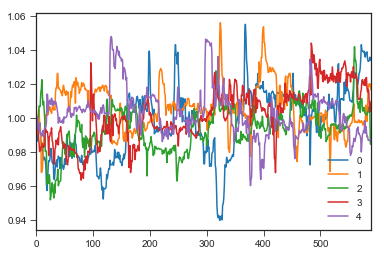

In [48]:
(prices / fundamentals).plot()

In [29]:
lower_c_price = []
upper_c_price = []
av_pf = []
for row in range(len(prices)):
    price_range = prices.iloc[row] / fundamentals.iloc[row]# / mc_fundamentals.iloc[row]
    #print(price_range)
    try:
        lower, upper = confidence_interval(price_range)
    except:
        lower, upper = np.mean(price_range), np.mean(price_range)
    av_pf.append(np.mean(price_range))
    lower_c_price.append(lower)
    upper_c_price.append(upper)

# Stylized facts

## Autocors

In [33]:
autocors = pd.DataFrame()
for col in prices:
    autocors[col] = [prices[col].pct_change().autocorr(lag=lag) for lag in range(25)]

In [35]:
lower_autocors = []
upper_autocors = []

for row in range(len(autocors)):
    autcor_range = autocors.iloc[row]
    try:
        lower, upper = confidence_interval(autcor_range)
    except:
        lower, upper = np.mean(autcor_range), np.mean(autcor_range)
    
    lower_autocors.append(lower)
    upper_autocors.append(upper)

## Kurtosis

In [36]:
lower_k, upper_k = confidence_interval(prices.pct_change().kurtosis())
lower_k, upper_k

(6.992251964888733, 14.984586623044063)

## Long memory

In [51]:
sim_hursts = []
for col in prices:
    H, c, dataz = compute_Hc(prices[col], kind='price', simplified=True)
    sim_hursts.append(H)

In [42]:
confidence_interval(sim_hursts)

(0.31032654555576494, 0.33592123526963363)

## Autocorrelation returns

In [43]:
confidence_interval(autocors.mean())

(0.028143637721355946, 0.030489530776021352)

## Autocorrelation absolute returns

In [44]:
confidence_interval(autocors.abs().mean())

(0.05043023978497391, 0.054074144427930335)